# Projeto - Análise de Risco de Crédito

A análise de risco de crédito é um componente essencial para instituições financeiras e credores, ajudando a determinar a capacidade de um cliente em cumprir suas obrigações contratuais. Tradicionalmente, essa análise era realizada por meio de métodos estatísticos convencionais e avaliações manuais, que, apesar de eficientes, possuem limitações em termos de precisão, escalabilidade e capacidade de adaptação a novos padrões de comportamento.

_Default_ é o termo utilizado para se referir à inadimplência, que é o descumprimento de obrigações e/ou condições de um empréstimo. Ele pode se referir tanto a financiamentos como dívidas de cartão e, normalmente, a inadimplência tem como principal motivo a incapacidade financeira do cliente.

O objetivo desse projeto é construir um modelo de Machine Learning que atenda à tarefa de prever qual cliente é mais provável de ser inadimplente, dado um conjunto de dados a respeito dele.

Serão realizadas as etapas de análise exploratória dos dados, processamento e treinamento dos modelos.

In [1]:
# Bibliotecas de análise de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Processamento dos dados e Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
# Métodos de balanceamento
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
# Modelos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Carregando os dados

Os dados utilizados nesse projeto são do ...

In [3]:
data_path = r"C:\Users\gabri\OneDrive\Documentos\Projetos Data Science\DSNP\Datasets\acquisition_train.csv"

cred_risk_df = pd.read_csv(data_path)

cred_risk_df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [4]:
print('Dimensões do conjunto\n',
      f'\nEntradas: {cred_risk_df.shape[0]}',
      f'\nVariáveis: {cred_risk_df.shape[1]}')

print('\nNomes das colunas:')
cred_risk_df.columns

Dimensões do conjunto
 
Entradas: 45000 
Variáveis: 43

Nomes das colunas:


Index(['ids', 'target_default', 'score_1', 'score_2', 'score_3', 'score_4',
       'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed',
       'last_borrowed_in_months', 'credit_limit', 'reason', 'income',
       'facebook_profile', 'state', 'zip', 'channel', 'job_name', 'real_state',
       'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts',
       'n_issues', 'application_time_applied', 'application_time_in_funnel',
       'email', 'external_data_provider_credit_checks_last_2_year',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_first_name',
       'external_data_provider_fraud_score', 'lat_lon', 'marketing_channel',
       'profile_phone_number', 'reported_income', 'shipping_state',
       'shipping_zip_code', 'profile_tags', 'user_agent', 'target_fraud'],
      dtype='object')

### Dicionário de Variáveis

Observando os nomes de colunas e as primeiras entradas, podemos inferir algumas coisas. Se analisamos cada variável em seus valores únicos, podemos deduzir o significado delas e organizar o seguinte dicionário de variáveis:

- `ids`: Identificadores dos clientes, aparentemente são _strings_ aleatórias que não serão úteis para a análise;
- `score_1, score_2`: Variáveis de pontuação codificadas;
- `score_3, score_4, score_5, score_6`: Variáveis numéricas que dizem respeito a pontuação do cliente. Pode ser útil para identificar inadimplentes;
- `risk_rate`: Taxa de risco (de inadimplência?) do cliente (valores entre 0 e 1 indicam uma probabilidade);
- `last_amount_borrowed`: Registro do valor do último empréstimo do cliente;
- `last_borrowed_in_months`: Número de meses desde o último empréstimo (36., nan, 60.);
- `credit_limit`: Limite de crédito para determinado cliente;
- `income`: Renda anual do cliente;
- `state, zip, channel, job_name, real_state`: Dados demográficos e informações sobre trabalho dos clientes (codificadas);
- `n_bankruptcies`: Número de falências registradas do cliente ( 0.,  1., nan,  2.,  3.,  4.,  5.);
- `n_defaulted_loans`: Número de calotes nos empréstimos (0., 1., nan, 2., 3., 5.);
- `n_accounts`: Número de contas (valor inteiro);
- `n_issues`: Número de problemas (valor inteiro);
- `application_time_applied`: Tempo de aplicação (Em horas. Não está claro a que se refere);
- `email`: Provedor de e-mail (outlook, gmail, etc);
- `external_data_provider_credit_checks_last_2_year`: Coluna com 0 ou nan. Checagem de crédito nos últimos dois anos;
- `external_data_provider_credit_checks_last_year`, `external_data_provider_credit_checks_last_month`: Checagem de crédito no último ano (0., nan, 1.) e último mês (2, 1, 3, 0);
- `external_data_provider_email_seen_before`: E-mail visto antes (possui valores nan e discrepantes, como -999)
- `external_data_provider_first_name`: Primeiro nome do cliente;
- `external_data_provider_fraud_score`: Pontuação de fraude (não faz parte do escopo da nossa análise);
- `lat_lon`: Tupla de valores de latitude e longitude;
- `marketing_channel`: Canal de marketing (convite e-mail, radio, lista de espera, website, etc);
- `profile_phone_number`: Número de telefone do cliente;
- `reported_income`: Renda informada pelo cliente (float, mas poderia ser int);
- `shipping_state`, `shipping_zip_code`: Estado de residência do cliente (BR-MG, BR-SP, etc) e CEP (int);
- `profile_tags`: Lista com dicionários contendo o que parece ser tags de identificação dos clientes ("{'tags': ['n19', 'n8']}", "{'tags': ['n6', 'n7', 'nim']}"). PS: Dicionários formatados como string.
- `user_agent`: Informações sobre pontos de acesso;
- `target_fraud`: Variável que classifica uma transação fraudulenta ou não (fora do escopo do projeto);
- `target_default (Alvo)`: Variável que classifica um cliente inadimplente ou não (False, True, nan).

### Análise da variável-alvo

Como visto, a variável `target_default` é o nosso alvo, contendo informações dos clientes regulares e inadimplentes. Vamos verificar algumas informações sobre ela, como valores únicos e proporções das classes.

In [5]:
print('Valores na variável-alvo:', cred_risk_df['target_default'].unique())

Valores na variável-alvo: [False True nan]


Antes de iniciar qualquer análise, vimos que o alvo possui valores ausentes, de modo que será necessário remover essas entradas (caso a proporção no conjunto não seja muito grande) para podermos ter o dado real da distribuição de classes no conjunto.

In [6]:
target_null = cred_risk_df['target_default'].isna().sum()

print(f'Quantidade de valores nulos no alvo: {target_null}')
print(f'Proporção de nulos no alvo: {(target_null * 100/ cred_risk_df.__len__()).round(2)} %')

Quantidade de valores nulos no alvo: 3259
Proporção de nulos no alvo: 7.24 %


De fato, temos 7,24% de dados nulos no alvo. Apesar de não ser uma quantidade desprezível, não é uma proporção tão grande a ponto de afetar nossa análise. Assim, essas entradas serão removidas.

In [7]:
def remove_target_nan(df: pd.DataFrame):
    cred_risk_df_clean = df.copy()

    nan_idx = cred_risk_df_clean.loc[cred_risk_df_clean['target_default'].isna()].index

    cred_risk_df_clean.drop(index = nan_idx, axis = 0, inplace = True)
    print('Valores nulos removidos!')

    return cred_risk_df_clean

In [8]:
cred_risk_df_clean = remove_target_nan(cred_risk_df)

Valores nulos removidos!


Agora, podemos olhar para a distribuição das classes no conjunto, através da análise de proporção.

In [9]:
print('Distribuição das classes:\n')

class_count = cred_risk_df_clean['target_default'].value_counts()

print(class_count)

print('\nProporção no conjunto: \n')

class_0 = (class_count.iloc[0] * 100/ cred_risk_df_clean.__len__()).round(2)
class_1 = (class_count.iloc[1] * 100/ cred_risk_df_clean.__len__()).round(2)

print(f'False: \t{class_0} %',
      f'\nTrue: \t{class_1} %')

Distribuição das classes:

target_default
False    35080
True      6661
Name: count, dtype: int64

Proporção no conjunto: 

False: 	84.04 % 
True: 	15.96 %


Temos portanto um problema desbalanceado, com 35 mil entradas (84,04%) que correspondem a clientes regulares, e 6661 entradas (15,96%) que representam clientes inadimplentes.

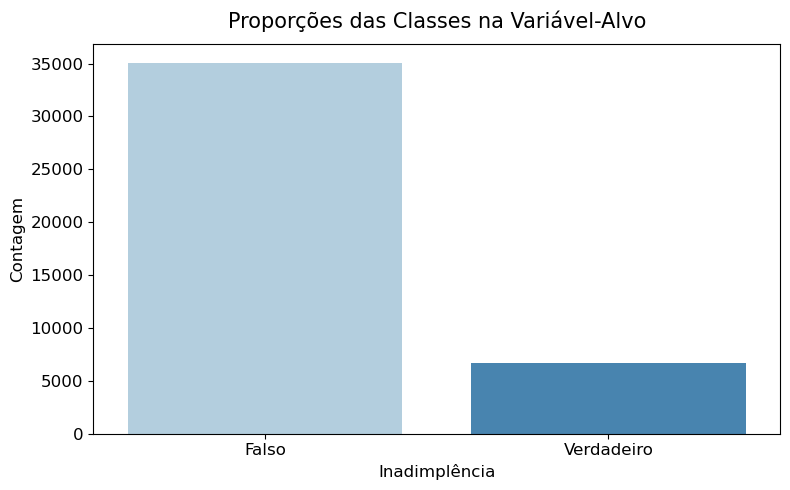

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.countplot(data = cred_risk_df_clean, x = 'target_default', palette = 'Blues', ax = ax)

ax.set_title('Proporções das Classes na Variável-Alvo', fontsize = 15, pad = 12)
ax.set_ylabel('Contagem', fontsize = 12)
ax.set_xlabel('Inadimplência', fontsize = 12)
ax.set_xticklabels(['Falso', 'Verdadeiro'], fontdict = {'fontsize': 12})
ax.set_yticks(ticks = np.arange(0, 4e4, 5e3), 
              labels = [i for i in range(0, 40000, 5000)], 
              fontdict = {'fontsize': 12})

fig.tight_layout()

O gráfico ajuda a visualizar melhor essas proporções. Os exemplos que fazem parte da coluna `Falso` são dos clientes regulares, enquanto o `Verdadeiro` diz respeito aos inadimplentes. Naturalmente, existe um proporção muito maior de clientes regulares.

Pensando nas próximas fases do processamento dos dados, podemos já codificar a variável-alvo para que ela contemple apenas valores binários de 0 e 1 para representar as classes. A classe 0 representará os clientes regulares, e a classe 1 os clientes inadimplentes. Utilizaremos para isso o Label Encoder.

In [11]:
def apply_label_encoder(df: pd.DataFrame):
    # Instanciar o objeto LabelEncoder
    le = LabelEncoder()

    # Ajustando os dados da variável-alvo
    le.fit(df['target_default'])

    # Aplicando a transformação
    df['target_default'] = le.transform(df['target_default'])
    print('Valores da variável-alvo: ', list(df['target_default'].unique()))

    return df

In [12]:
cred_risk_df_clean = apply_label_encoder(cred_risk_df_clean)

Valores da variável-alvo:  [0, 1]


Agora, temos uma variável-alvo que contém apenas valores 1 ou 0 para as respectivas classes de cliente inadimplente ou não. Nesta seção, portanto, tratamos os dados ausentes, analisamos as proporções das classes no conjunto e estruturamos o problema de classificação binária, ao codificar os valores das classes para 0 ou 1.

## Análise Exploratória

### Informações do conjunto de dados

Agora que vimos informações sobre a variável-alvo, vamos seguir com a análise para outras variáveis do conjunto. Começaremos analisando a quantidade de valores ausentes, as colunas que serão removidas, e aquelas que serão imputadas com novos valores para preencher os ausentes.

In [13]:
print('Quantidade de valores ausentes:', f'\n{cred_risk_df_clean.isna().sum().sort_values(ascending = False)[:20]}')

print('\nTipos das variáveis:', f'\n{cred_risk_df_clean.dtypes.value_counts()}')

Quantidade de valores ausentes: 
target_fraud                                        40384
last_amount_borrowed                                27608
last_borrowed_in_months                             27608
ok_since                                            24465
external_data_provider_credit_checks_last_2_year    21030
external_data_provider_credit_checks_last_year      14021
credit_limit                                        13109
n_issues                                            10923
facebook_profile                                     4153
marketing_channel                                    3308
job_name                                             2617
external_data_provider_email_seen_before             2085
lat_lon                                              1262
user_agent                                            656
n_bankruptcies                                        135
n_defaulted_loans                                      12
reason                                 

Vemos que existem colunas que possuem praticamente todos os valores ausentes. Iremos avaliar como abordar essas variáveis em breve. Com relação aos tipos de variáveis, vemos que a maior parte são numéricas do tipo `float` e `int`, totalizando 23.

### Tratamento de valores ausentes

Como vimos acima, existem variáveis com uma grande proporção de valores ausentes. Vamos visualizar os valores percentuais.

In [14]:
print('Valores ausentes por coluna, ordenados de forma decrescente (%):')
round((cred_risk_df_clean.isna().sum()) * 100 / cred_risk_df_clean.__len__(), 1).sort_values(ascending = False)

Valores ausentes por coluna, ordenados de forma decrescente (%):


target_fraud                                        96.7
last_amount_borrowed                                66.1
last_borrowed_in_months                             66.1
ok_since                                            58.6
external_data_provider_credit_checks_last_2_year    50.4
external_data_provider_credit_checks_last_year      33.6
credit_limit                                        31.4
n_issues                                            26.2
facebook_profile                                     9.9
marketing_channel                                    7.9
job_name                                             6.3
external_data_provider_email_seen_before             5.0
lat_lon                                              3.0
user_agent                                           1.6
n_bankruptcies                                       0.3
state                                                0.0
zip                                                  0.0
score_1                        

Variáveis sem nenhum valor ausente:             

* application_time_applied
* external_data_provider_fraud_score
* shipping_state
* external_data_provider_first_name
* profile_phone_number
* shipping_zip_code
* reported_income
* external_data_provider_credit_checks_last_month
* profile_tags
* email
* application_time_in_funnel
* ids
* n_accounts
* risk_rate
* score_1
* score_2
* score_3
* score_4
* score_5
* score_6
* reason
* n_defaulted_loans
* income
* state
* zip
* channel
* real_state
* target_default

Dentre as variáveis que possuem valores ausentes, algumas não possuem nenhum significado para nossa análise e serão removidas.  Particularmente, as variáveis que dizem respeito à tarefa de detecção de fraudes, que não faz parte do escopo desse projeto, serão removidas. São elas: `target_fraud` e `external_data_provider_fraud_score`. Outras variáveis simplesmente não possuem nenhum poder preditivo para análise (e.g nome ou e-mail que a pessoa usa, perfil do Facebook) ou são de difícil interpretabilidade (e.g pontos de acesso, horários, etc), como `ids`, `email`, `external_data_provider_first_name`, `profile_phone_number`, `facebook_profile`, `user_agent`, `application_time_applied`, `external_data_provider_credit_checks_last_year`, `external_data_provider_credit_checks_last_2_year`, `reason`, etc.

Dentre as variáveis codificadas, temos: `state, zip, channel, job_name, real_state, score_1 e score_2`. Para as variáveis que não contém muitos valores únicos, podemos usar a abordagem do OHE (_One Hot Enconding_) para transpô-las em novas colunas como variáveis numéricas binárias (0 ou 1).

In [15]:
cred_risk_df_clean[['state', 'zip', 'channel', 'job_name', 'real_state', 'score_1', 'score_2']].nunique().sort_values()

channel           1
real_state        5
score_1           7
score_2          35
state            50
zip             823
job_name      30543
dtype: int64

Apenas as variáveis `score_1` e `real_state` possuem poucos valores únicos. A variável `channel`, assim como `external_data_provider_credit_checks_last_2_year`, possui apenas um valor que por si só não oferece nenhum poder preditivo. Iremos removê-las posteriormente.

Poderíamos argumentar que o fato do cliente ser inadimplente pode ter a ver com seu emprego. Vamos analisar se existe algum tipo de emprego, na coluna `job_name`, que indique essa relação. 

In [16]:
count_jobs = cred_risk_df_clean.loc[cred_risk_df['target_default'] == True]['job_name'].value_counts()

print(count_jobs[:10], '\n') 

print('Sumário Estatístico')

print(count_jobs.describe(percentiles = [.5, .75, .95, .99, .999]).round(1))

job_name
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIaUIfpgwbYh438CvSsT5QB8=    19
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIbOy82w5K5LALfp4MHskDUE=    17
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIVf4E/iI7qK+Lfl5hxoWW2A=    16
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSISzmgfFzT+qYrtqTHkJFqpA=    12
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIUGp9a+9oBSLvyI5Jdz9fNg=    12
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIb4ADj/ykkhgM886TEQ8yrI=    11
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIh/cdCiaVzVo/KVM2JldD+WiCpSDcTmA605zSPwbuinf0=    11
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIV56G3kjZxQ0yMeb3IU2UKE=    11
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxo

Os resultados aqui são interessantes. Os 5 primeiros itens da lista representam títulos de empregos que mais se repetem quando o cliente é inadimplente.

A maioria dos empregos aparece apenas uma vez para os inadimplentes, enquanto que os casos de empregos que se repetem mais do que 4 vezes é menor do 1%. Isso mostra que essa variável não parece possui um poder preditivo muito elevado. Além disso, existe o problema da falta de interpretabilidade ao considerar que todas as entradas estão codificadas.

Por esse motivo, a variável `job_name` será removida nesse primeiro momento.



Vamos analisar mais algumas variáveis, visando conhecer suas distribuições estatísticas e valores únicos. Assim, poderemos escolher quais iremos manter, quais remover e quais imputar valores.

### Construção de funções para análise

#### Informações das variáveis

Essa função tem como objetivo imprimir informações relevantes sobre a variável em questão, como:

- Proporção de valores ausentes
- Sumário estatístico
- Valores únicos
- Tipo da variável

In [17]:
def col_info(df: pd.DataFrame, col: str):
    isna_proportion = (df.isna().sum() * 100 / df.__len__()).sort_values(ascending = False).round(2)

    print(f'Variável {col}\n')

    print(f'Proporção de valores ausentes: {isna_proportion[col]}%\n')
    
    if df[col].dtypes == 'O':
      
      print(f'Sumário Estatístico {col}:\n')
      print(df[col].describe())

      print(f'\nValores únicos:',
            f'\n{df[col].unique()}',
            f'\n\nQuantidade de valores únicos: {df[col].nunique()}')
                  
    else:
      
      print(f'Sumário Estatístico {col}:\n')
      print(df[col].describe().round(1))
      
      print(f'\nValores únicos:',
            f'\n{df[col].unique()}',
            f'\n\nQuantidade de valores únicos: {df[col].nunique()}')
            
      print('\nTipo da variável: ', df[col].dtypes)

#### Plotar Boxplot

Essa função oferece uma visualização da estatística da variável através de um Boxplot da variável.

In [18]:
def plot_boxplot(df: pd.DataFrame, col: str):
    fig, ax = plt.subplots(figsize = (12, 3))
    
    sns.boxplot(
        data = df, 
        x = col, 
        ax = ax, 
        palette = 'Reds', 
        showmeans = True
        )

    ax.set_title(f'Boxplot da Variável {col}', fontsize = 14)
    ax.set_xlabel(f'{col}', fontsize = 12)

    fig.tight_layout()

#### Boxplot de comparação com a variável-alvo

Essa visualização comparar as distribuições estatísticas da variável quando filtrada pelas classes do alvo, que nos diz se o cliente é inadimplente ou não.

In [19]:
def comparison_boxplot(df: pd.DataFrame, col: str):
    fig, ax = plt.subplots(figsize = (5, 6))

    sns.boxenplot(
        data = df,
        x = 'target_default', 
        y = col,
        hue = 'target_default',
        palette = 'Blues',
        legend = False,
        ax = ax,
    )

    ax.set_title(f'Comparação com o alvo - Variável {col}', fontsize = 14)
    ax.set_xlabel('Inadimplente', fontsize = 12)
    ax.set_ylabel(f'{col}', fontsize = 12)
    ax.set_xticklabels(['0', '1'], fontdict = {'fontsize': 12})

    fig.tight_layout()

#### Remover Outliers

Por fim, essa função remove _outliers_ de variáveis que necessitam desse tratamento. A amplitude do intervalo que definirá o IQR pode ser escolhido através do argumento `threshold`, que define o fator multiplicativo do terceiro quartil.

In [20]:
def outlier_removal(df: pd.DataFrame, col: str, threshold: int):

    q3 = df[col].quantile(.75)
    q1 = df[col].quantile(.25)

    iqr = q3 - q1
    iqr_upper = iqr + threshold * q3

    print(f'Limite superior do IQR da variável {col}: {iqr_upper}')
    n_outliers = df.loc[df[col] > iqr_upper].shape[0]
    idx = df.loc[df[col] > iqr_upper].index

    if n_outliers < 1000:
        print('Removendo outliers...')
        df.drop(idx, axis = 0, inplace = True)
        print(f"\n{n_outliers} outliers removidos.")

### Análise das variáveis individuais

#### ok_since

A variável `ok_since` provavelmente nos passa a informação de quanto tempo o cliente está em uma situação normal de crédito.

In [329]:
col_info(cred_risk_df_clean, 'ok_since')

Variável ok_since

Proporção de valores ausentes: 58.61%

Sumário Estatístico ok_since:

count    17276.0
mean        35.2
std         21.6
min          0.0
25%         17.0
50%         32.0
75%         50.0
max        141.0
Name: ok_since, dtype: float64

Valores únicos: 
[ nan  50.  11.  35.  16.  19.  23.  43.  17.  29.  18.  56.  38.  93.
  27.  44.  13.   8.  66.  33.  12.  30.  24.  21.   7.  63.  51.  31.
  73.  49.   4.  48.  14.  76.  36.   5.  46.  41.  34.  59.  61.  55.
  84.  28.  75.   6.  67.  39.  52.  72.  10.  45.  32.  62.   0.  58.
  15.  78.  70.   9.  22.  80.  20.  68.  37.   3.  53.  60.  74.  26.
  47.   1.  42.  57.  40.  54.  65.  81.  25.  77.  71.  69.  64.  86.
  79.  82.   2.  83.  85. 103. 135.  97. 101.  90. 130. 141. 108.  88.
  95. 122.  87.] 

Quantidade de valores únicos: 100

Tipo da variável:  float64


Essa variável apresenta muitos valores ausentes. Porém, seu sumário estatístico não apresenta valores discrepantes e possui muitos valores distintos. Vamos mantê-la preenchendo os valores ausentes por sua mediana e testar no modelo.

Pode ser convertida para tipo _int_.

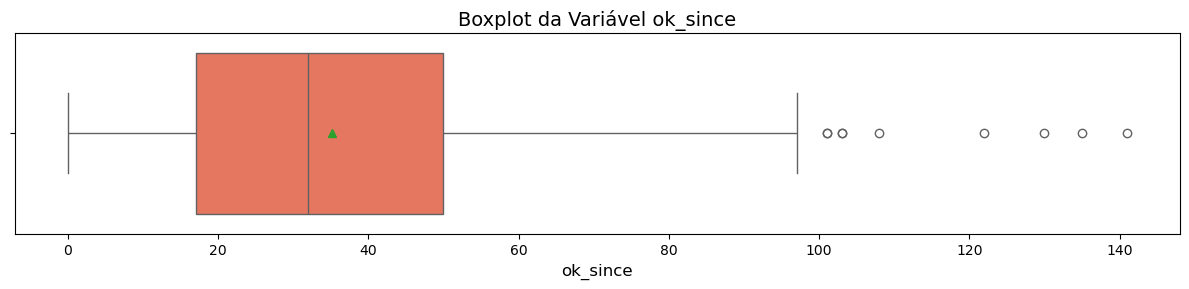

In [330]:
plot_boxplot(cred_risk_df_clean, 'ok_since')

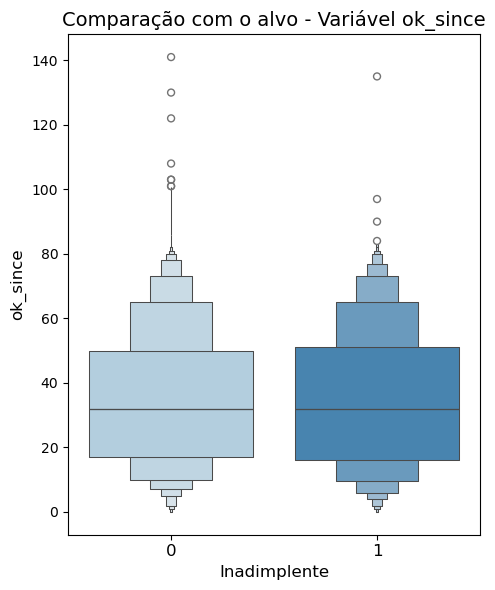

In [331]:
comparison_boxplot(cred_risk_df_clean, 'ok_since')

Interessante notar que as distribuições estatísticas são parecidas na variável `ok_since` para ambas as classes no alvo. Contudo, fica claro que existem mais clientes classificados como regulares - note como a calda da classe 0 é maior, e como existem mais _outliers_ para valores altos. Essa análise deixa claro que existem outros fatores que influenciam na inadimplência, para além do tempo de fidelidade no pagamento do crédito.

#### last_amount_borrowed

A variável `last_amount_borrowed` traz informações dos valores que foram emprestados aos clientes na última vez.

In [332]:
col_info(cred_risk_df_clean, 'last_amount_borrowed')

Variável last_amount_borrowed

Proporção de valores ausentes: 66.14%

Sumário Estatístico last_amount_borrowed:

count    14133.0
mean     13328.1
std       7918.7
min       1005.2
25%       7210.3
50%      12011.0
75%      18030.2
max      35059.6
Name: last_amount_borrowed, dtype: float64

Valores únicos: 
[25033.92      nan  7207.92 ...  5022.86 14766.42  4226.74] 

Quantidade de valores únicos: 13480

Tipo da variável:  float64


Apesar da grande quantidade de valores ausentes, ainda temos muitos valores únicos. Não existem muitos valores discrepantes também, pois os valores da média e da mediana são próximos na estatística descritiva da variável. O maior problema, de fato, são as muitas entradas com valores ausentes. Não temos como saber o motivo específico dessa falta, mas temos duas alternativas: preencher com a mediana, ou zeros.

Iremos preencher com zero, assumindo que as entradas não foram preenchidas pois dizem respeito a clientes que não pegaram nenhum empréstimo e são, portanto, regulares.

Como a proporção é menor do que os 84% de clientes regulares, pode ser esse o caso.

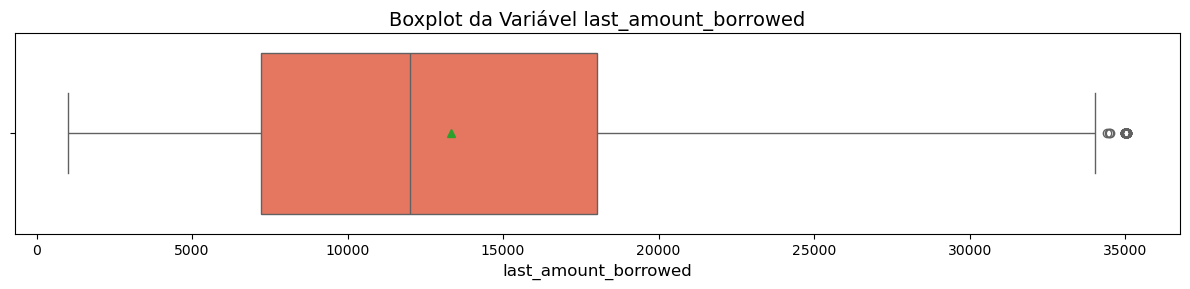

In [333]:
plot_boxplot(cred_risk_df_clean, 'last_amount_borrowed')

#### last_borrowed_in_months

Essa variável diz respeito a quantidade de meses desde o último empréstimo de um cliente.

In [334]:
col_info(cred_risk_df_clean, 'last_borrowed_in_months')

Variável last_borrowed_in_months

Proporção de valores ausentes: 66.14%

Sumário Estatístico last_borrowed_in_months:

count    14133.0
mean        40.6
std          9.4
min         36.0
25%         36.0
50%         36.0
75%         36.0
max         60.0
Name: last_borrowed_in_months, dtype: float64

Valores únicos: 
[36. nan 60.] 

Quantidade de valores únicos: 2

Tipo da variável:  float64


Note que a proporção de valores ausentes é o mesmo da variável que diz a quantidade do último empréstimo. Não sabemos se correspondem às mesmas entradas.

Vamos verificar se as entradas ausentes correspondem às mesmas para as duas variáveis, `last_amount_borrowed` e `last_borrowed_in_months`. Iremos utilizar o método _loc_ com duas condições: filtrar as entradas ausentes para as duas colunas.

In [335]:
print('Quantidade de entradas ausentes comuns entre as duas variáveis:')
print(round(cred_risk_df.loc[(cred_risk_df['last_amount_borrowed'].isna()) & (cred_risk_df['last_borrowed_in_months']).isna()].shape[0] * 100/ cred_risk_df.__len__(), 2), '%')

Quantidade de entradas ausentes comuns entre as duas variáveis:
66.57 %


Verificamos que todas as entradas ausentes de `last_borrowed_in_months` correspondem às da variável `last_amount_borrowed`. Iremos imputar o valor zero, considerando que se tratam dos mesmos clientes que não pediram nenhum empréstimo.

#### credit_limit

Essa variável mostra o limite de crédito liberado para os clientes do banco.

In [336]:
col_info(cred_risk_df_clean, 'credit_limit')

Variável credit_limit

Proporção de valores ausentes: 31.41%

Sumário Estatístico credit_limit:

count     28632.0
mean      33877.2
std       36142.0
min           0.0
25%        9975.0
50%       25213.0
75%       46492.5
max      448269.0
Name: credit_limit, dtype: float64

Valores únicos: 
[    0. 39726.    nan ... 10431. 36262. 17942.] 

Quantidade de valores únicos: 19336

Tipo da variável:  float64


A média do limite de crédito é de R$ 33877, e a mediana é de R$ 25213. Essa discrepância nesses dois parâmetros se deve ao fato de haver muitos _outliers_ nessa variável, _i.e_, pessoas que possuem um limite de crédito muito alto.

Essa variável já possui uma proporção menor de valores ausentes, tornando possível imputar os valores a partir das informações do sumário estatístico, especificamente a mediana. Iremos fazer esse tratamento nas etapas posteriores. Outra coisa é o tipo da variável, que pode ser convertido para _int_.

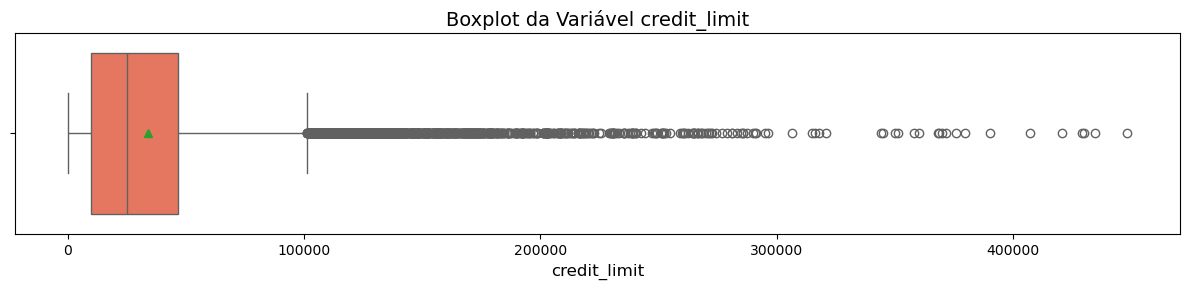

In [337]:
plot_boxplot(cred_risk_df_clean, 'credit_limit')

Fazendo a análise da distribuição estatística por classe:

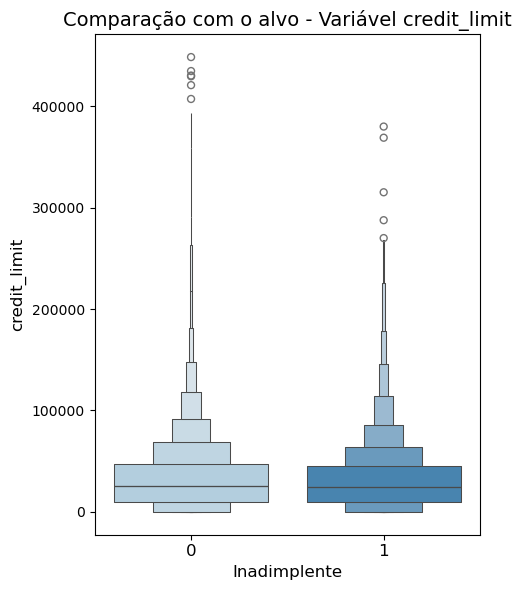

In [338]:
comparison_boxplot(cred_risk_df_clean, 'credit_limit')

Note que os _outliers_ são bem informativos para essa variável. Vemos que os clientes classificados como normais possuem limites de crédito mais altos se comparados com os limites de crédito dos inadimplentes. Isso faz sentido, uma vez que o banco irá considerar o histórico de bom pagador para liberar crédito.

#### n_issues

Essa variável reporta a quantidade de problemas (reclamações dos clientes ou problemas da empresa com o cliente?). Não há mais detalhes sobre ela.

In [339]:
col_info(cred_risk_df_clean, 'n_issues')

Variável n_issues

Proporção de valores ausentes: 26.17%

Sumário Estatístico n_issues:

count    30818.0
mean        11.0
std          4.6
min          0.0
25%          8.0
50%         10.0
75%         14.0
max         49.0
Name: n_issues, dtype: float64

Valores únicos: 
[18. 14. nan 19.  9.  7.  8. 16. 20.  5. 13. 12. 23. 22. 11.  6. 15. 17.
 21.  4. 10.  3. 24. 25. 30.  2. 27. 37. 26. 29. 28. 40. 34. 49.  1. 31.
 32. 39. 42. 33. 36. 35.  0. 41. 38.] 

Quantidade de valores únicos: 44

Tipo da variável:  float64


Outra variável que iremos preencher os valores ausentes com a mediana, uma vez que a proporção de valores nulos é de 25,7%. Além disso, pode ser convertida para tipo _int_.

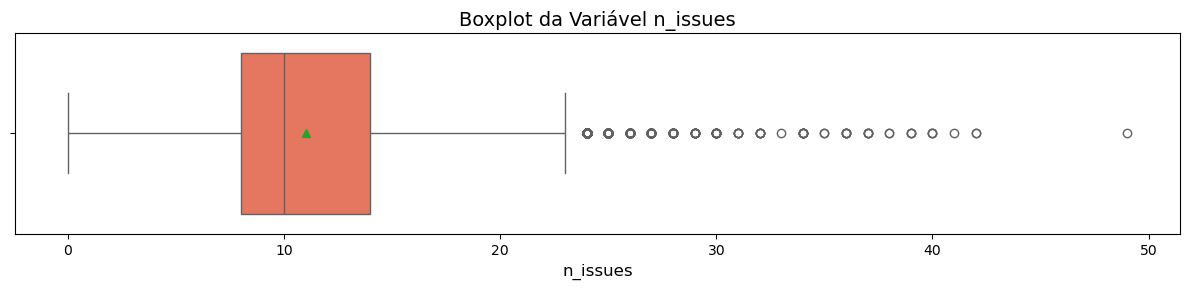

In [340]:
plot_boxplot(cred_risk_df_clean, 'n_issues')

#### external_data_provider_email_seen_before

In [341]:
col_info(cred_risk_df_clean, 'external_data_provider_email_seen_before')

Variável external_data_provider_email_seen_before

Proporção de valores ausentes: 5.0%

Sumário Estatístico external_data_provider_email_seen_before:

count    39656.0
mean        12.7
std        125.7
min       -999.0
25%         11.0
50%         27.0
75%         43.0
max         59.0
Name: external_data_provider_email_seen_before, dtype: float64

Valores únicos: 
[  51.   17.    9.   38.   46.   21.   16.   37.    6.   nan   10.   29.
   43.   59.   54.   13.   52.    4.   31.   40.   -1. -999.   26.   48.
   50.    5.    3.   39.   11.    0.   58.   55.    2.    1.   53.   15.
   23.   24.   44.   14.   25.   34.   35.   12.   27.   49.    7.   36.
   47.   57.   20.    8.   18.   30.   42.   28.   41.   56.   32.   33.
   19.   22.   45.] 

Quantidade de valores únicos: 62

Tipo da variável:  float64


Essa variável apresenta dois valores discrepantes de -999 e -1. Juntas, essas entradas somam poucos mais de 1100, de modo que representam uma pequena parcela do conjunto de dados e serão removidas.

In [342]:
idx_999 = cred_risk_df_clean.loc[cred_risk_df_clean['external_data_provider_email_seen_before'] == -999.].index
idx_1 = cred_risk_df_clean.loc[cred_risk_df_clean['external_data_provider_email_seen_before'] == -1.].index

cred_risk_df_clean = cred_risk_df_clean.copy()

# Removendo entradas com valores -999
cred_risk_df_clean.drop(index = idx_999, axis = 0, inplace = True)
# Removendo entradas com valores -1
cred_risk_df_clean.drop(index = idx_1, axis = 0, inplace = True)

n_999 = cred_risk_df_clean.loc[cred_risk_df_clean['external_data_provider_email_seen_before'] == -999.].shape[0]

print('Número de entradas discrepantes: ', n_999)

Número de entradas discrepantes:  0


Agora temos um sumário estatístico correto. Iremos preencher os valores ausentes que restaram pelo valor da mediana.

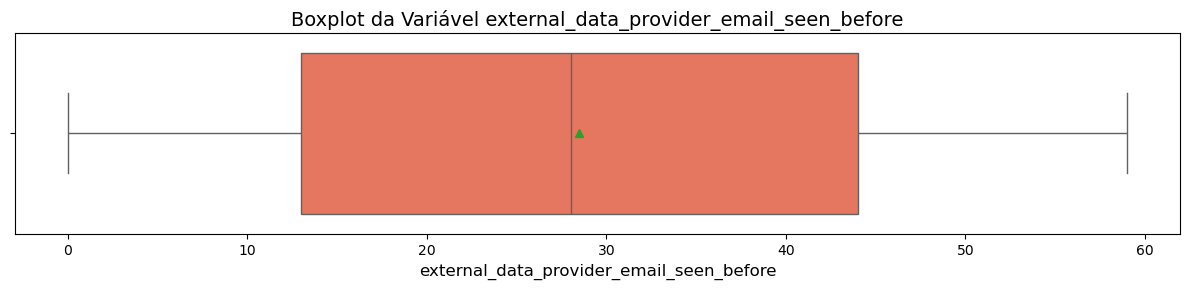

In [343]:
plot_boxplot(cred_risk_df_clean, 'external_data_provider_email_seen_before')

#### n_bankruptcies

In [344]:
col_info(cred_risk_df_clean, 'n_bankruptcies')

Variável n_bankruptcies

Proporção de valores ausentes: 0.32%

Sumário Estatístico n_bankruptcies:

count    40424.0
mean         0.1
std          0.3
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          5.0
Name: n_bankruptcies, dtype: float64

Valores únicos: 
[ 0.  1. nan  2.  3.  4.  5.] 

Quantidade de valores únicos: 6

Tipo da variável:  float64


No caso dessa variável, iremos substituir os valores ausentes por zero. Além disso, ela pode ser convertida para o tipo _int_.

In [345]:
bankruptcies_isna = cred_risk_df_clean['n_bankruptcies'].isna().sum()

if bankruptcies_isna > 0:
    cred_risk_df_clean['n_bankruptcies'].fillna(0, inplace = True)
    print('Valores preenchidos')

Valores preenchidos


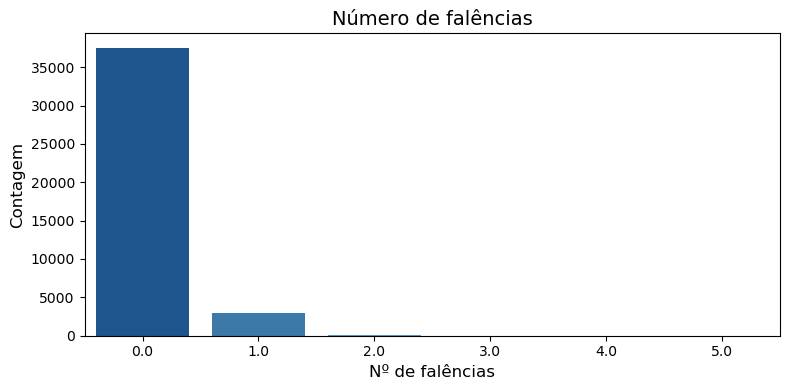

In [346]:
fig,ax = plt.subplots(figsize = (8, 4))

sns.countplot(cred_risk_df_clean, x = 'n_bankruptcies', palette = 'Blues_r', ax = ax)

ax.set_title('Número de falências', fontsize = 14)
ax.set_ylabel('Contagem', fontsize = 12)
ax.set_xlabel('Nº de falências', fontsize = 12)

fig.tight_layout()

Como é de se esperar, a maioria dos clientes nunca reportou nenhuma falência. A proporção daqueles que reportaram uma falência é mais de 8 vezes menor do que a quantidade de clientes que nunca faliu, enquanto que as proporções dos que reportaram duas ou mais falências é ínfima.

#### marketing_channel

Essa variável mostra quantos clientes vieram de cada canal de marketing.

In [347]:
col_info(cred_risk_df_clean, 'marketing_channel')

Variável marketing_channel

Proporção de valores ausentes: 7.96%

Sumário Estatístico marketing_channel:

count       37326
unique          9
top       Website
freq         9890
Name: marketing_channel, dtype: object

Valores únicos: 
['Invite-email' 'Radio-commercial' 'Waiting-list' 'Website' 'Twitter'
 'Facebook' nan 'Instagram' 'Invite-web' 'LinkedIn'] 

Quantidade de valores únicos: 9


Vemos então que a maioria chegou através do site. Além desse, são considerados diversos outros canais como e-mail, redes sociais e rádio. A variável possui valores ausentes que serão substituídos pelo valor da moda.

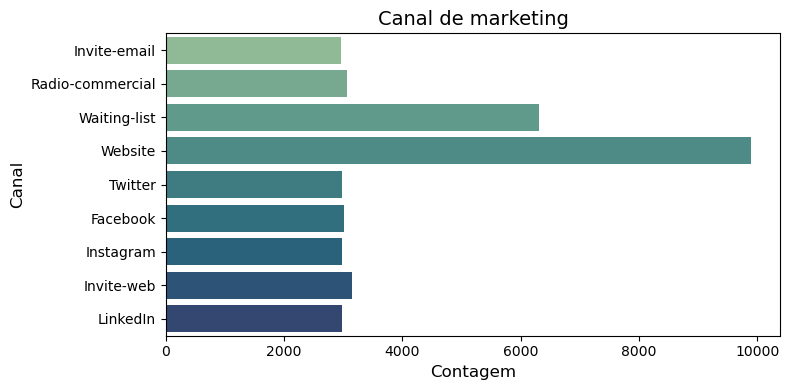

In [348]:
fig,ax = plt.subplots(figsize = (8, 4))

mkt_count = cred_risk_df_clean['marketing_channel'].value_counts().sort_values(ascending = False)

sns.countplot(cred_risk_df_clean, y = 'marketing_channel', palette = 'crest')

ax.set_title('Canal de marketing', fontsize = 14)
ax.set_ylabel('Canal', fontsize = 12)
ax.set_xlabel('Contagem', fontsize = 12)

fig.tight_layout()

Como podemos ver, após o site, o meio mais comum de captação de clientes é a lista de espera. O restante dos meios ficam empatados.

#### n_defaulted_loans

Essa variável reporta quantos clientes já tiveram empréstimos inadimplentes no passado, informando a quantidade.

In [349]:
col_info(cred_risk_df_clean, 'n_defaulted_loans')

Variável n_defaulted_loans

Proporção de valores ausentes: 0.03%

Sumário Estatístico n_defaulted_loans:

count    40540.0
mean         0.0
std          0.1
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          5.0
Name: n_defaulted_loans, dtype: float64

Valores únicos: 
[ 0.  1. nan  2.  3.  5.] 

Quantidade de valores únicos: 5

Tipo da variável:  float64


In [350]:
cred_risk_df_clean['n_defaulted_loans'].value_counts()

n_defaulted_loans
0.0    40380
1.0      139
2.0       16
3.0        4
5.0        1
Name: count, dtype: int64

Vemos que a esmagadora maioria nunca teve nenhum empréstimo inadimplente. O número de clientes com 1 ou mais inadimplências no histórico não passa de 0,01% do conjunto de dados.

Além disso, a variável possui poucas entradas com valores ausentes que podem ser substituídas por zero, dado que é o valor mais provável.

#### n_accounts

Essa variável diz respeito ao número de contas que determinado cliente possui. É uma variável numérica com poucos valores ausentes, como podemos ver.

In [351]:
col_info(cred_risk_df_clean, 'n_accounts')

Variável n_accounts

Proporção de valores ausentes: 0.0%

Sumário Estatístico n_accounts:

count    40552.0
mean        10.6
std          4.6
min          1.0
25%          7.0
50%         10.0
75%         13.0
max         49.0
Name: n_accounts, dtype: float64

Valores únicos: 
[18. 14. 10. 19. 11.  9.  8.  7. 16.  6. 20.  5. 13.  4. 12. 23. 22. 15.
 17. 21. 24.  3. 28.  2. 25. 30. 27. 37. 26. 29. 33. 35. 34. 40. 49. 31.
  1. 32. 39. 42. 36. 41. 38.] 

Quantidade de valores únicos: 43

Tipo da variável:  float64


Como podemos ver da distribuição estatística da variável, ela é enviesada para valores em torno de 10, que é a sua mediana. Não precisaremos nos preocupar em imputar valores, pois ela já não apresenta nenhuma entrada ausente. Ela pode ser convertida para o tipo int.

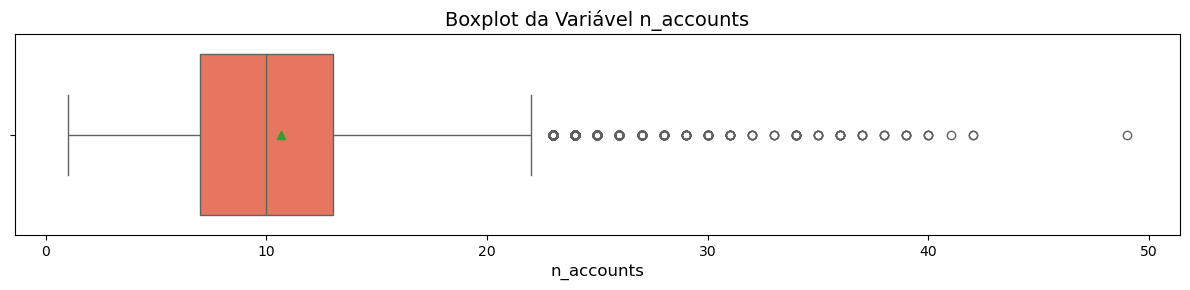

In [352]:
plot_boxplot(cred_risk_df_clean, 'n_accounts')

#### risk_rate

Essa variável quantifica a probabilidade de risco do cliente se tornar inadimplente. Ela já não possui nenhum valor ausente, e varia desde 0% de chance até 90%.

In [353]:
col_info(cred_risk_df_clean, 'risk_rate')

Variável risk_rate

Proporção de valores ausentes: 0.0%

Sumário Estatístico risk_rate:

count    40552.0
mean         0.3
std          0.1
min          0.0
25%          0.2
50%          0.3
75%          0.4
max          0.9
Name: risk_rate, dtype: float64

Valores únicos: 
[0.4  0.24 0.29 0.32 0.18 0.44 0.43 0.33 0.36 0.22 0.12 0.27 0.34 0.38
 0.25 0.13 0.15 0.19 0.23 0.28 0.21 0.35 0.41 0.42 0.26 0.31 0.3  0.51
 0.08 0.17 0.2  0.09 0.45 0.46 0.37 0.16 0.39 0.49 0.11 0.54 0.48 0.04
 0.59 0.07 0.5  0.58 0.53 0.47 0.1  0.14 0.05 0.52 0.72 0.55 0.56 0.06
 0.57 0.61 0.7  0.6  0.62 0.65 0.8  0.78 0.63 0.77 0.66 0.03 0.64 0.73
 0.75 0.67 0.68 0.69 0.74 0.   0.71 0.9  0.76 0.02 0.81] 

Quantidade de valores únicos: 81

Tipo da variável:  float64


Interessante que a variável parece seguir uma distribuição aproxiadamente normal em torno da média, que é 0,3. Porém, ainda existe uma cauda para valores maiores que 0,6, que deixa a distribuição levemente enviesada.

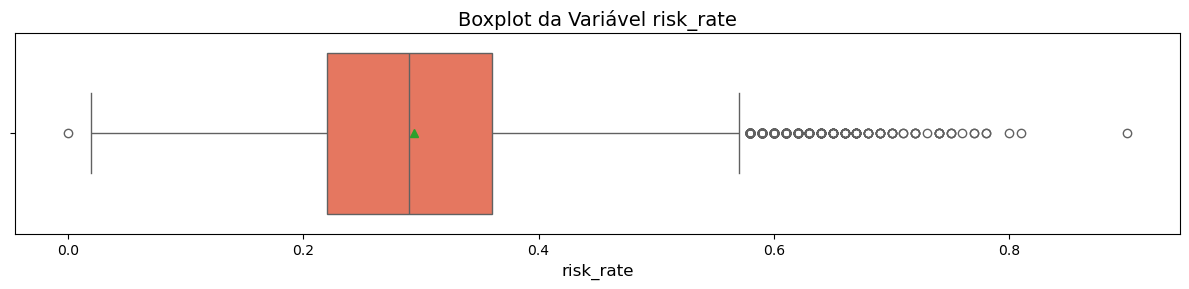

In [354]:
plot_boxplot(cred_risk_df_clean, 'risk_rate')

A distribuição estatística dessa variável está muito boa também. Vemos que a maioria dos clientes são classificados como tendo até 30% de chances de serem inadimplentes, e apenas uma pequena parcela possui mais do que 60% de chance de se tornar inadimplente, segundo essa estimativa.

#### income

A variável `income` diz respeito à renda dos clientes. Note que a variação, em dólares, vai desde US\$ 4821 até US$ 5 milhões, que é um claro _outlier_. Iremos tratar os valores discrepantes nesse caso, pois afeta a visualização da distribuição estatística e pode enviesar os dados na modelagem.

In [355]:
col_info(cred_risk_df_clean, 'income')

Variável income

Proporção de valores ausentes: 0.0%

Sumário Estatístico income:

count      40552.0
mean       71144.4
std        52514.8
min         4821.2
25%        44021.4
50%        60048.5
75%        85035.7
max      5000027.8
Name: income, dtype: float64

Valores únicos: 
[ 65014.12 100018.91  65023.65 ... 106020.9  185018.07  34013.65] 

Quantidade de valores únicos: 37809

Tipo da variável:  float64


Vamos remover as entradas muito discrepantes.

In [356]:
outlier_removal(cred_risk_df_clean, 'income', threshold = 2)

Limite superior do IQR da variável income: 211085.7575
Removendo outliers...

509 outliers removidos.


Como podemos ver, 509 entradas foram removidas e o corte foi em US\$ 211 mil. Agora, temos um conjunto de dados mais representativo da população geral, no que diz respeito à renda.

In [357]:
col_info(cred_risk_df_clean, 'income')

Variável income

Proporção de valores ausentes: 0.0%

Sumário Estatístico income:

count     40043.0
mean      67981.6
std       33802.3
min        4821.2
25%       43555.9
50%       60031.5
75%       85019.6
max      211022.5
Name: income, dtype: float64

Valores únicos: 
[ 65014.12 100018.91  65023.65 ... 106020.9  185018.07  34013.65] 

Quantidade de valores únicos: 37302

Tipo da variável:  float64


Vamos comparar as distribuições no boxplot antes e depois da remoção dos valores discrepantes.

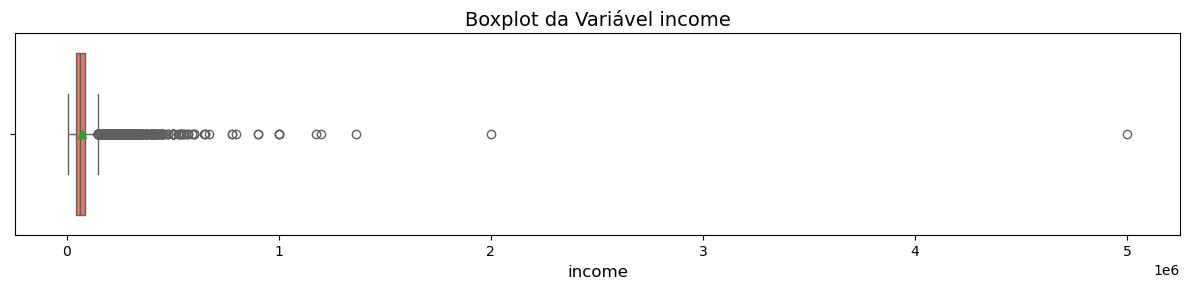

In [358]:
plot_boxplot(cred_risk_df, 'income')

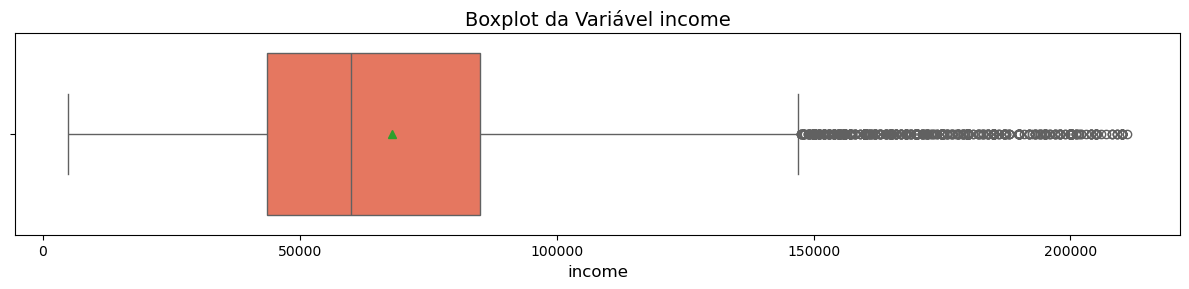

In [359]:
plot_boxplot(cred_risk_df_clean, 'income')

Note que o valor máximo se distanciava muito do restante dos dados. Isso certamente não seria benéfico para o nosso modelo. Agora, temos uma visualização mais clara da estatística da variável, sem ter removido todos os _outliers_. Ao analisar o boxplot de comparação entre as classes temos:

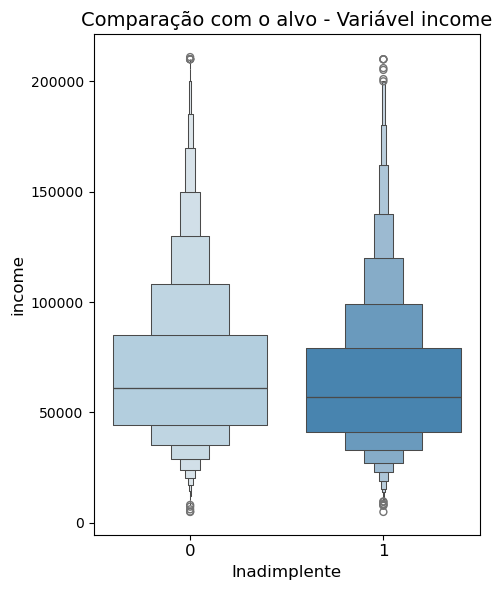

In [360]:
comparison_boxplot(cred_risk_df_clean, 'income')

Não há grandes diferenças entre os dois gráficos para essa variável, além de alguns _outliers_ a mais para a classe dos inadimplentes.

#### reported_income

A variável `reported_income` mostra a renda reportada pelos clientes. Vamos verificar as informações do atributo.

In [361]:
col_info(cred_risk_df_clean, 'reported_income')

Variável reported_income

Proporção de valores ausentes: 0.0%

Sumário Estatístico reported_income:

count     40043.0
mean          inf
std           NaN
min         403.0
25%       51051.5
50%      101873.0
75%      151221.0
max           inf
Name: reported_income, dtype: float64

Valores únicos: 
[ 57849.   4902. 163679. ...  26246. 129844. 112766.] 

Quantidade de valores únicos: 35998

Tipo da variável:  float64


Vemos que ele possui valores infinitos entre suas entradas, o que é errado. Iremos tratar esse problema, removendo as entradas com valores infinitos.

In [362]:
n_inf_rows = cred_risk_df_clean.loc[cred_risk_df_clean['reported_income'] == np.inf].shape[0]

print('A variável possui {} entradas com valores tidos como infinito.'.format(n_inf_rows))

A variável possui 64 entradas com valores tidos como infinito.


In [363]:
# Copiar o conjunto de dados antes de remover as entradas
cred_risk_df_clean = cred_risk_df_clean.copy()

# Índices das entradas com valores inf
inf_idx = cred_risk_df_clean.loc[cred_risk_df_clean['reported_income'] == np.inf].index

# Remover as entradas
cred_risk_df_clean.drop(inf_idx, axis = 0, inplace = True)
print('Valores infinitos removidos!')

Valores infinitos removidos!


In [364]:
col_info(cred_risk_df_clean, 'reported_income')

Variável reported_income

Proporção de valores ausentes: 0.0%

Sumário Estatístico reported_income:

count    3.997900e+04
mean     1.065106e+13
std      2.599635e+14
min      4.030000e+02
25%      5.096300e+04
50%      1.017630e+05
75%      1.510770e+05
max      6.355500e+15
Name: reported_income, dtype: float64

Valores únicos: 
[ 57849.   4902. 163679. ...  26246. 129844. 112766.] 

Quantidade de valores únicos: 35997

Tipo da variável:  float64


Agora que removemos os valores infinitos, ainda temos _outliers_ que serão removidos também. Note que enquanto a maioria dos valores ficam na ordem de $10^5$, existem valores que chegam à ordem de $10^{15}$. Se vermos o boxplot, mal podemos distinguir as estatísticas.

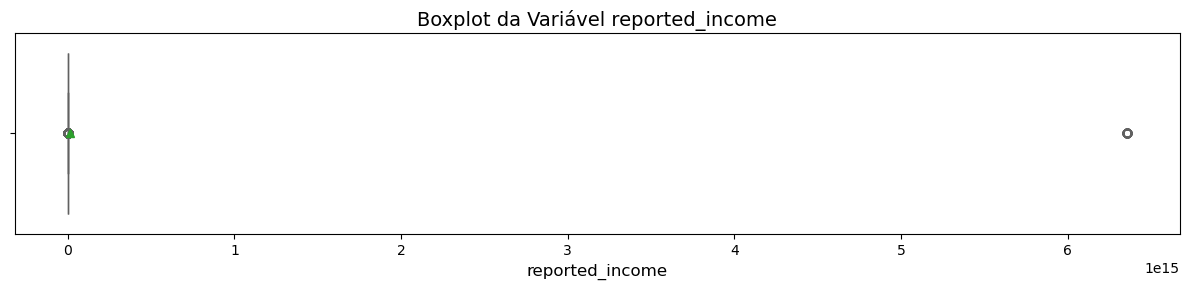

In [365]:
plot_boxplot(cred_risk_df_clean, 'reported_income')

Assim, iremos aplicar a função para remoção desses _outliers_, considerando um limiar de 3.

In [366]:
outlier_removal(cred_risk_df_clean, 'reported_income', threshold = 2)

Limite superior do IQR da variável reported_income: 402268.0
Removendo outliers...

303 outliers removidos.


Poucas entradas foram removidas, mas já melhorou bastante o sumário estatístico da variável.

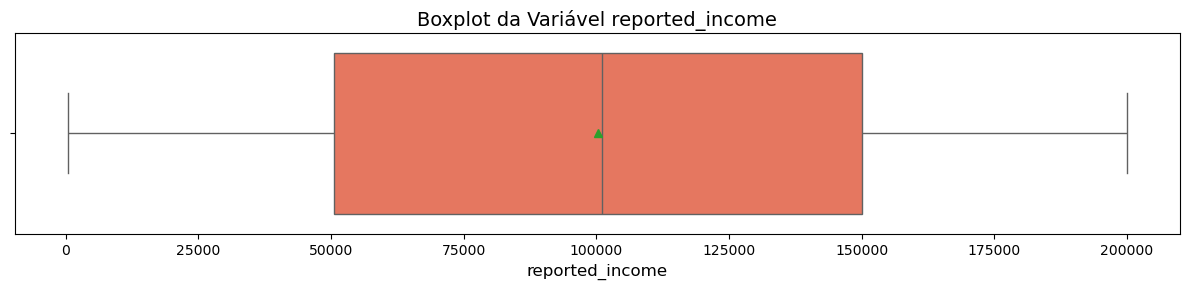

In [367]:
plot_boxplot(cred_risk_df_clean, 'reported_income')

Agora, podemos ver novamente a estatística da variável sem as entradas infinitas e _outliers_.

In [368]:
col_info(cred_risk_df_clean, 'reported_income')

Variável reported_income

Proporção de valores ausentes: 0.0%

Sumário Estatístico reported_income:

count     39676.0
mean     100394.1
std       57522.2
min         403.0
25%       50565.5
50%      100988.5
75%      150067.8
max      200000.0
Name: reported_income, dtype: float64

Valores únicos: 
[ 57849.   4902. 163679. ...  26246. 129844. 112766.] 

Quantidade de valores únicos: 35992

Tipo da variável:  float64


#### application_time_in_funnel

In [369]:
col_info(cred_risk_df_clean, 'application_time_in_funnel')

Variável application_time_in_funnel

Proporção de valores ausentes: 0.0%

Sumário Estatístico application_time_in_funnel:

count    39676.0
mean       247.8
std        146.3
min          0.0
25%        120.0
50%        248.0
75%        375.0
max        500.0
Name: application_time_in_funnel, dtype: float64

Valores únicos: 
[444 346   6 406 240 169  74 184 420   7 243  53 296 316 216 165 448 350
 291 131 173 366  18   5  30 458 258   9 411 239  48 400 362 251 410  57
  93  99 159 436 153 113  28 290  49 274  42 456  32 312 288 313 364  60
 193  45 398  35 485 405 332 425  80 146  50 194 337 254  96 360  77 203
 242 116 292 126 278 482  88 383 144 253 209 423 500  65 266 178 289 111
 465 472 132  84 196 112 442 130 120 345 208  72  19  15 441 267 387 192
 319 272 374 453  89 421 433  21 435  70 463 419 213 256  71 305 408 475
 238 379 107 220 235 125 100  41 177 175 393  27 300 214 318 212  63 417
 497 273 249 321 414  37 394 299  25 121 151 357 344  67 341 174 388 114
 403 325  51  92 

Essa variável está no formato correto, não possui valores nulos e a estatística está boa. Vemos que existe quase uma concordância entre média e mediana, o que mostra que não possui _outliers_. Ela pode ser convertida para int.

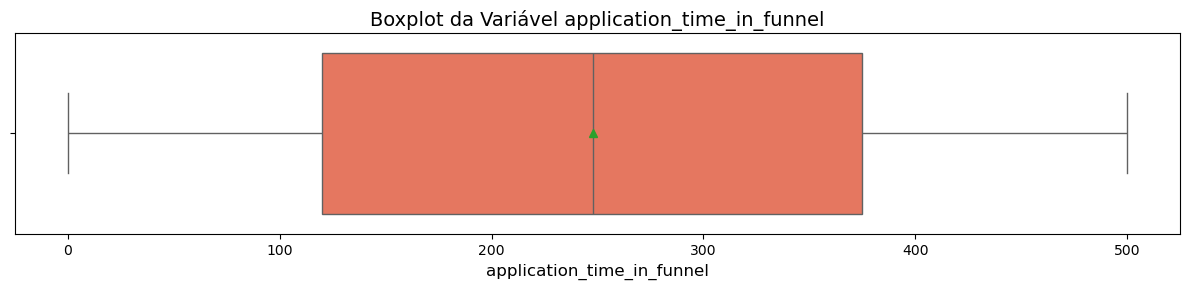

In [370]:
plot_boxplot(cred_risk_df_clean, 'application_time_in_funnel')

#### score_3

Começando agora com as variáveis de pontuação do cliente. As variáveis `score_1` e `score_2` são codificadas e categóricas, de modo que não seria possível realizar a mesma análise que nas outras. Contudo, os atributos `score_3` até `score_6` são todas numéricas. Apesar de não termos explicações de o que eles estão pontuando, podemos verificar as distribuições dos dados e tratar para o uso no modelo.

In [371]:
col_info(cred_risk_df_clean, 'score_3')

Variável score_3

Proporção de valores ausentes: 0.0%

Sumário Estatístico score_3:

count    39676.0
mean       347.1
std        110.1
min          0.0
25%        270.0
50%        340.0
75%        420.0
max        990.0
Name: score_3, dtype: float64

Valores únicos: 
[350. 370. 360. 510. 500. 300. 250. 330. 390. 340. 460. 400. 310. 190.
 210. 590. 280. 260. 320. 450. 240. 430. 470. 420. 270. 290. 570. 180.
 220. 620. 520. 560. 490. 200. 440. 230. 480. 410. 170. 160. 140. 780.
 380. 540. 550. 650. 530.  80. 150. 580. 100. 690. 630. 640. 110. 600.
 120. 130. 670. 610. 730. 660.  70. 680. 760. 700. 720. 820.  90. 710.
  50.  30.  20. 750. 810. 790. 770.  60.  40. 740. 910. 860. 990. 880.
 850.   0.] 

Quantidade de valores únicos: 86

Tipo da variável:  float64


Essa variável também apresenta um bom sumário estatístico, sem valores nulos ou _outliers_.

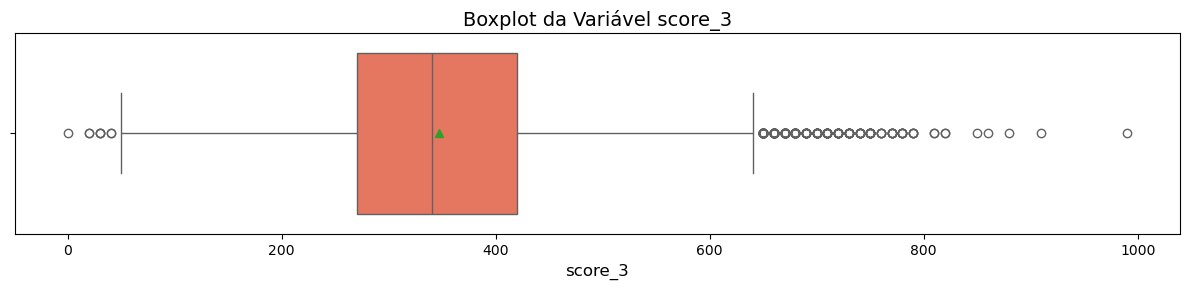

In [372]:
plot_boxplot(cred_risk_df_clean, 'score_3')

De fato, vemos que a distribuição estatística dos dados da variável `score_3` apresenta alguns _outliers_ mas eles não são muito discrepantes e ainda permitem que visualizemos as estatísticas entre quartis.

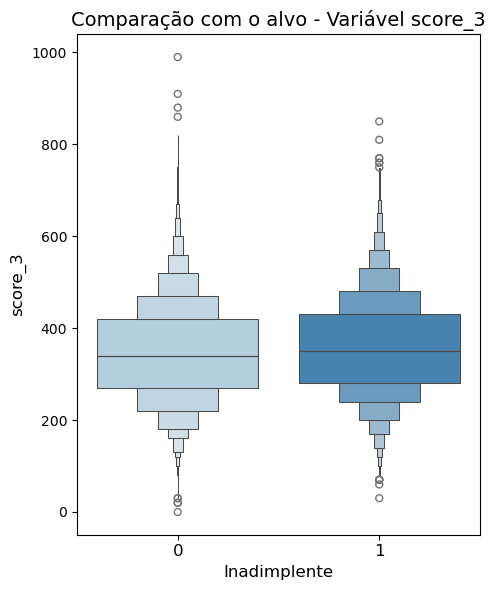

In [373]:
comparison_boxplot(cred_risk_df_clean, 'score_3')

Na comparação das distribuições dos dados com relação ao alvo, não vemos grandes diferenças entre os quartis. Porém, para a classe de clientes regulares, novamente observa-se que a cauda do boxplot é mais prolongada e possui mais _outliers_.

#### score_4

In [374]:
col_info(cred_risk_df_clean, 'score_4')

Variável score_4

Proporção de valores ausentes: 0.0%

Sumário Estatístico score_4:

count    39676.0
mean       100.0
std          3.2
min         86.2
25%         97.9
50%        100.0
75%        102.1
max        114.0
Name: score_4, dtype: float64

Valores únicos: 
[101.80083171  97.06261531 100.02707252 ... 102.37778011 100.47609005
 101.09581302] 

Quantidade de valores únicos: 39676

Tipo da variável:  float64


Novamente, a variável apresenta uma boa estatística, sem _outliers_ ou valores nulos.

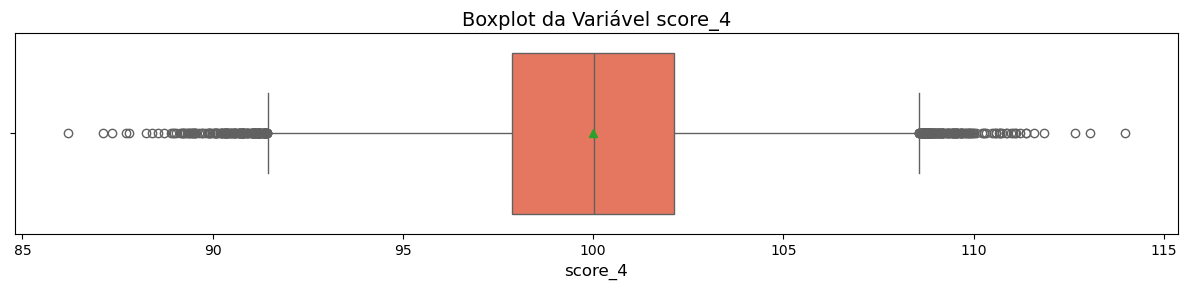

In [375]:
plot_boxplot(cred_risk_df_clean, 'score_4')

Vemos que os quartis não possuem uma amplitude tão grande, com uma concentração de dados em torno da média que estabelece _outliers_ para valores menores que o primeiro quartil e maiores que o terceiro.

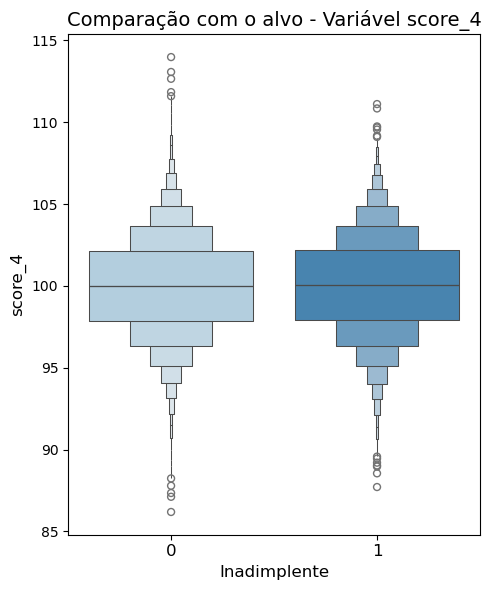

In [376]:
comparison_boxplot(cred_risk_df_clean, 'score_4')

Nessa análise de comparação entre as classes, vemos que, enquanto o intervalo entre quartis permanece parecido para ambas as classes, temos uma pequena diferença para clientes regulares, que tendem a ter mais exemplos na cauda da distribuição.

#### score_5

In [377]:
col_info(cred_risk_df_clean, 'score_5')

Variável score_5

Proporção de valores ausentes: 0.0%

Sumário Estatístico score_5:

count    39676.0
mean         0.5
std          0.3
min          0.0
25%          0.3
50%          0.5
75%          0.7
max          1.0
Name: score_5, dtype: float64

Valores únicos: 
[0.25955467 0.94265452 0.3519176  ... 0.53093815 0.21469687 0.01136926] 

Quantidade de valores únicos: 39676

Tipo da variável:  float64


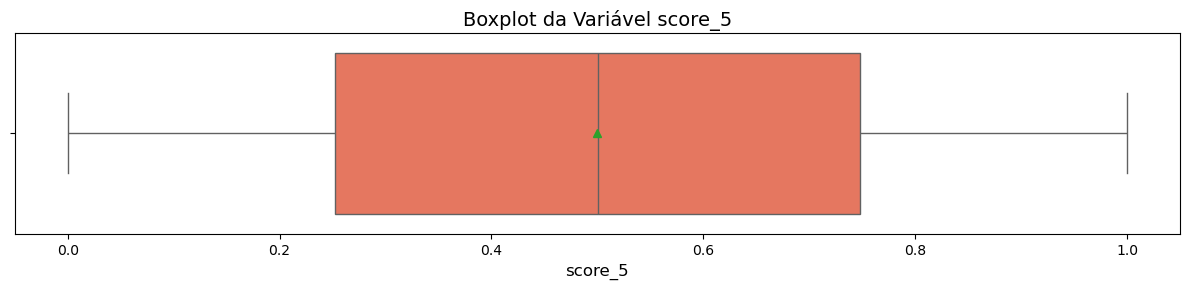

In [378]:
plot_boxplot(cred_risk_df_clean, 'score_5')

Pelos valores variarem entre 0 e 1, esse atributo pode estar medindo algum tipo de probabilidade.

#### score_6

In [379]:
col_info(cred_risk_df_clean, 'score_6')

Variável score_6

Proporção de valores ausentes: 0.0%

Sumário Estatístico score_6:

count    39676.0
mean        99.9
std         10.0
min         60.7
25%         93.2
50%        100.0
75%        106.6
max        142.2
Name: score_6, dtype: float64

Valores únicos: 
[108.42727282  92.00254553 112.89245295 ...  93.68774717  86.75907422
  97.36291829] 

Quantidade de valores únicos: 39676

Tipo da variável:  float64


Para visualizar melhor esse sumário estatístico, vamos plotar o boxplot:

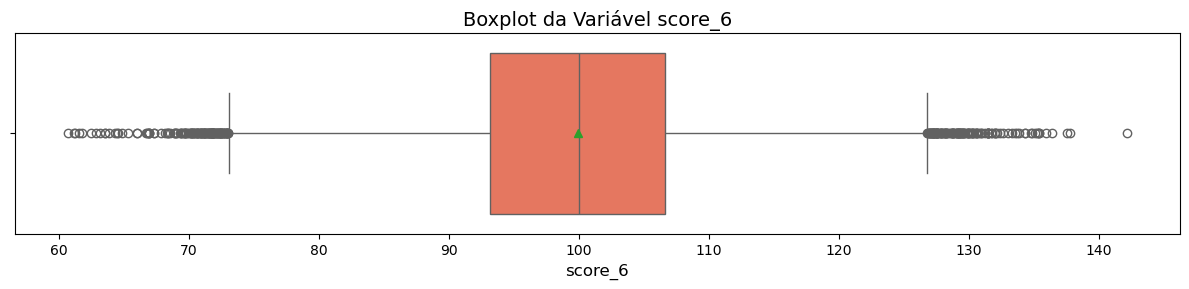

In [380]:
plot_boxplot(cred_risk_df_clean, 'score_6')

## Processamento dos dados

### Imputar valores ausentes

Agora que mapeamos todas as variáveis e adquirimos uma noção das distribuições estatísticas de cada uma, podemos começar a processar os dados. Iremos imputar os valores e remover os atributos irrelevantes nesse primeiro momento.

#### Critérios para remoção de variáveis

* Baixo poder preditivo (e.g `facebook_profile`, `profile_phone_number`);
* Baixa interpretabilidade devido a codificação (`state`, `job_name`);
* Dificíl formatação dos dados que dificulta a interpretação (e.g `user_agent`, `profile_tags`);
* Possuir apenas um valor único (e.g `channel`);
* Estar fora do escopo do problema.


In [381]:
cred_risk_df_proc = cred_risk_df_clean.copy()

cols_to_drop = ['target_fraud', 'external_data_provider_fraud_score',
                'ids', 'email', 'external_data_provider_first_name',
                'profile_phone_number', 'profile_tags', 'facebook_profile',
                'user_agent', 'state', 'zip', 'job_name', 'channel',
                'shipping_zip_code', 
                'external_data_provider_credit_checks_last_month',
                'application_time_applied', 'reason', 'real_state', 
                'external_data_provider_credit_checks_last_year',
                'external_data_provider_credit_checks_last_2_year']

cred_risk_df_proc.drop(columns = cols_to_drop, axis = 1, inplace = True)

print('Nova Dimensão do Conjunto')
print(f'\nEntradas: {cred_risk_df_proc.shape[0]}',
      f'\nVariáveis: {cred_risk_df_proc.shape[1]}')

Nova Dimensão do Conjunto

Entradas: 39676 
Variáveis: 23


Variáveis que iremos imputar o valor da mediana:

* `ok_since`
* `n_issues`
* `credit_limit`
* `external_data_provider_email_seen_before`

Variáveis que iremos imputar o valor zero:

* `last_amount_borrowed`
* `last_borrowed_in_months`
* `n_bankrupticies`
* `n_defaulted_loans`

Para variáveis categóricas, iremos imputar a moda.

#### Variáveis numéricas

Como definimos durante a análise exploratória dos dados, algumas das variáveis numéricas terão seus valores imputados com zero. São elas: `last_amount_borrowed`, `last_borrowed_in_months`, `n_defaulted_loans`, `n_bankrupticies`. O restante das variáveis com valores ausentes terão a mediana como valor a ser imputado.

In [382]:
# Instanciar o objeto para imputar valores baseados na mediana
num_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Selecionando as colunas para preencher com zero
cols_to_fill_0 = ['last_amount_borrowed', 'last_borrowed_in_months', 'n_defaulted_loans', 'n_bankruptcies']
cred_risk_df_proc[cols_to_fill_0].fillna(value = 0, inplace = True)

# Filtrando os atributos numéricos
num_cols = cred_risk_df_proc.select_dtypes(exclude = 'O').columns

# Imputar valores da mediana nas variáveis numéricas
num_imputer = num_imputer.fit(cred_risk_df_proc.loc[:, num_cols])
cred_risk_df_proc.loc[:, num_cols] = num_imputer.transform(cred_risk_df_proc.loc[:, num_cols])

#### Variáveis categóricas

Entre as variáveis categóricas, apenas `marketing_channel` terá valores imputados com a moda.

In [383]:
# Instanciando o objeto para imputar valores baseados na moda
cat_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

# Filtro para variáveis categóricas
cat_cols = cred_risk_df_proc.select_dtypes(include = 'O').columns

# Imputar moda nas variáveis categóricas
cat_imputer = cat_imputer.fit(cred_risk_df_proc.loc[:, cat_cols])
cred_risk_df_proc.loc[:, cat_cols] = cat_imputer.transform(cred_risk_df_proc.loc[:, cat_cols])

In [384]:
cred_risk_df_proc.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,...,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_email_seen_before,lat_lon,marketing_channel,reported_income,shipping_state
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,...,0.0,0.0,18.0,18.0,444,51.0,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,BR-MT
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,12005.99,36.0,...,0.0,0.0,14.0,14.0,346,17.0,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,BR-RS
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,...,0.0,0.0,10.0,10.0,6,9.0,"(-28.748023890412284, -51.867279334353995)",Waiting-list,163679.0,BR-RR
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,12005.99,36.0,...,1.0,0.0,19.0,19.0,406,38.0,"(-17.520650158450454, -39.75801139933186)",Waiting-list,1086.0,BR-RN
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,12005.99,36.0,...,0.0,0.0,11.0,10.0,240,46.0,"(-16.574259446978008, -39.90990074785962)",Invite-email,198618.0,BR-MT


### Feature Engineering

#### Latitude e longitude

In [385]:
print('Quantidade de valores ausentes na coluna lat_lon: %d' % cred_risk_df_proc['lat_lon'].isna().sum())

Quantidade de valores ausentes na coluna lat_lon: 0


Iremos aplicar uma transformação na coluna `lat_lon` de modo a criar dois novos atributos, um para latitude e outro para longitude.

In [386]:
# Transformar o tipo da coluna em str
cred_risk_df_proc['lat_lon'] = cred_risk_df_proc['lat_lon'].astype(str)

# Criar os dois novos atributos
cred_risk_df_proc[['latitude', 'longitude']] = cred_risk_df_proc['lat_lon'].str.strip('()').str.split(',', expand= True)

# Transformando o tipo das colunas novas para float
cred_risk_df_proc['latitude'] = cred_risk_df_proc['latitude'].astype(float)
cred_risk_df_proc['longitude'] = cred_risk_df_proc['longitude'].astype(float)

# Remover a coluna original e a última entrada criada
cred_risk_df_proc.drop(columns = ['lat_lon'], axis = 1, inplace = True)
cred_risk_df_proc.drop(index = cred_risk_df_proc.index[-1], axis = 0, inplace = True)

cred_risk_df_proc.tail()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,...,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_email_seen_before,marketing_channel,reported_income,shipping_state,latitude,longitude
44994,0,1Rk8w4Ucd5yR3KcqZzLdow==,/tdlnWjXoZ3OjdtBXzdOJQ==,620.0,92.087698,0.456206,111.333512,0.18,12005.99,36.0,...,0.0,9.0,9.0,228,14.0,Website,17888.0,BR-RO,-8.796830,-63.856620
44995,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,280.0,96.379531,0.416693,103.667082,0.17,14766.42,36.0,...,0.0,7.0,7.0,72,7.0,Facebook,73417.0,BR-GO,-22.486891,-44.909011
44996,0,smzX0nxh5QlePvtVf6EAeg==,vJyc9xom9v7hwFMPTIpmKw==,370.0,96.124977,0.692196,97.977973,0.27,12005.99,36.0,...,0.0,16.0,16.0,51,1.0,Waiting-list,26246.0,BR-RO,-12.881450,-46.435453
44997,0,e4NYDor1NOw6XKGE60AWFw==,ky19q4V1ZqgL3jnHX0wKDw==,280.0,102.377780,0.530938,93.687747,0.30,12005.99,36.0,...,0.0,6.0,6.0,476,27.0,Waiting-list,101252.0,BR-SP,-23.888982,-50.645313
44998,1,smzX0nxh5QlePvtVf6EAeg==,6J1ZMTzN5GKHXnhM4J1JbA==,240.0,100.476090,0.214697,86.759074,0.37,12005.99,36.0,...,0.0,10.0,10.0,35,2.0,Instagram,129844.0,BR-SP,-5.147699,-37.983868


Na coluna `shipping_state` podemos tirar o prefixo 'BR'.

In [387]:
cred_risk_df_proc['shipping_state'] = cred_risk_df_proc['shipping_state'].str.split('-', expand = True)[1]

Agora temos um conjunto de dados limpo e com novos atributos interessantes para análise e treinamento.

In [388]:
cred_risk_df_proc.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,...,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_email_seen_before,marketing_channel,reported_income,shipping_state,latitude,longitude
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,...,0.0,18.0,18.0,444,51.0,Invite-email,57849.0,MT,-29.151546,-51.138646
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,12005.99,36.0,...,0.0,14.0,14.0,346,17.0,Radio-commercial,4902.0,RS,-19.687711,-47.941515
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,...,0.0,10.0,10.0,6,9.0,Waiting-list,163679.0,RR,-28.748024,-51.867279
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,12005.99,36.0,...,0.0,19.0,19.0,406,38.0,Waiting-list,1086.0,RN,-17.520650,-39.758011
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,12005.99,36.0,...,0.0,11.0,10.0,240,46.0,Invite-email,198618.0,MT,-16.574259,-39.909901


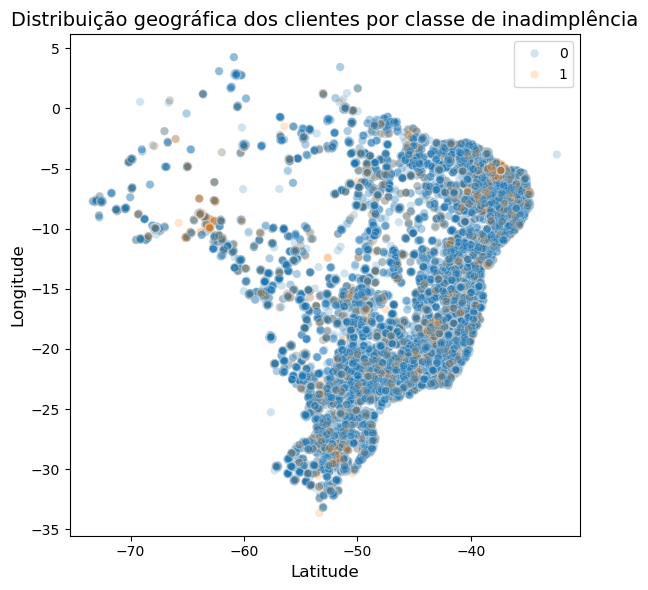

In [389]:
fig, ax = plt.subplots(figsize = (6, 6))

sns.scatterplot(cred_risk_df_proc, 
                x = 'longitude', 
                y = 'latitude',
                hue = 'target_default',
                alpha = .2)

ax.set_title('Distribuição geográfica dos clientes por classe de inadimplência', fontsize = 14)
ax.set_xlabel('Latitude', fontsize = 12)
ax.set_ylabel('Longitude', fontsize = 12)

ax.legend()

fig.tight_layout()

### Visualização de correlação e histogramas

Vamos selecionar algumas colunas que contém valores numéricos para visualizar os histogramas e gráficos de dispersão que mostrem as correlações entre os atributos. Para isso, vamos usar o  `pairplot` do Seaborn.

Se consideramos apenas os atributos de `score` numéricos, vemos que todos seguem uma distribuição aproximadamente normal, exceto pelo `score_5`. E isso é o padrão tanto para a classe de clientes regulares como para a classe de clientes inadimplentes. Ao observarmos as correlações nos gráficos de dispersão, os pontos que diferem as classes parecem bem misturados, sem mostrar nenhuma região do gráfico onde prevaleça uma das classes, indicando um grande potencial de previsão.

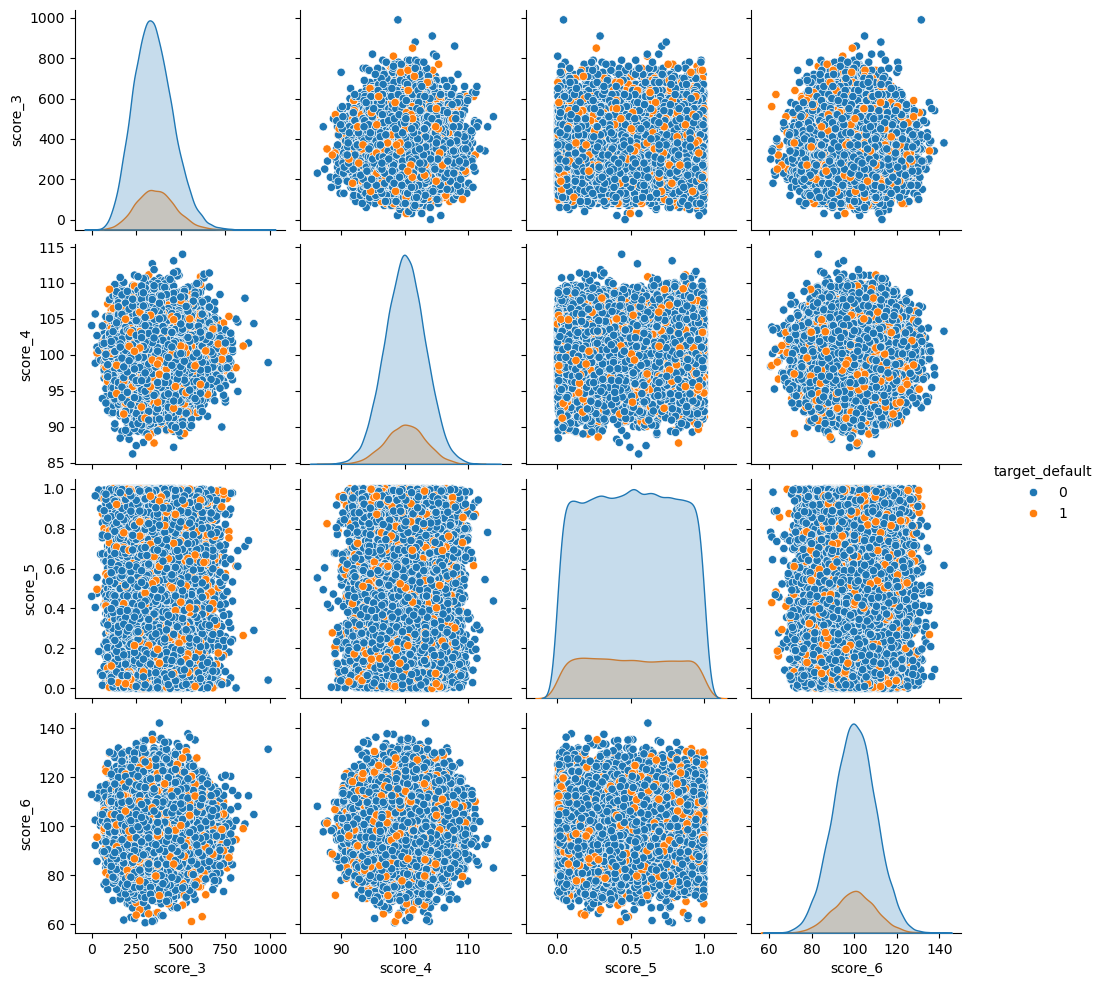

In [393]:
cols = ['score_3', 'score_4', 'score_5', 'score_6']

sns.pairplot(cred_risk_df_proc, vars = cols, hue = 'target_default')

Praticamente todas as distribuições das variáveis `score` seguem uma curva normal. Olhando para os gráficos de dispersão, vemos que os dados estão bem misturados, de modo que nenhuma variável apresenta qualquer correlação distinguível e nenhuma das classes prevalesce em determinada região do gráfico.

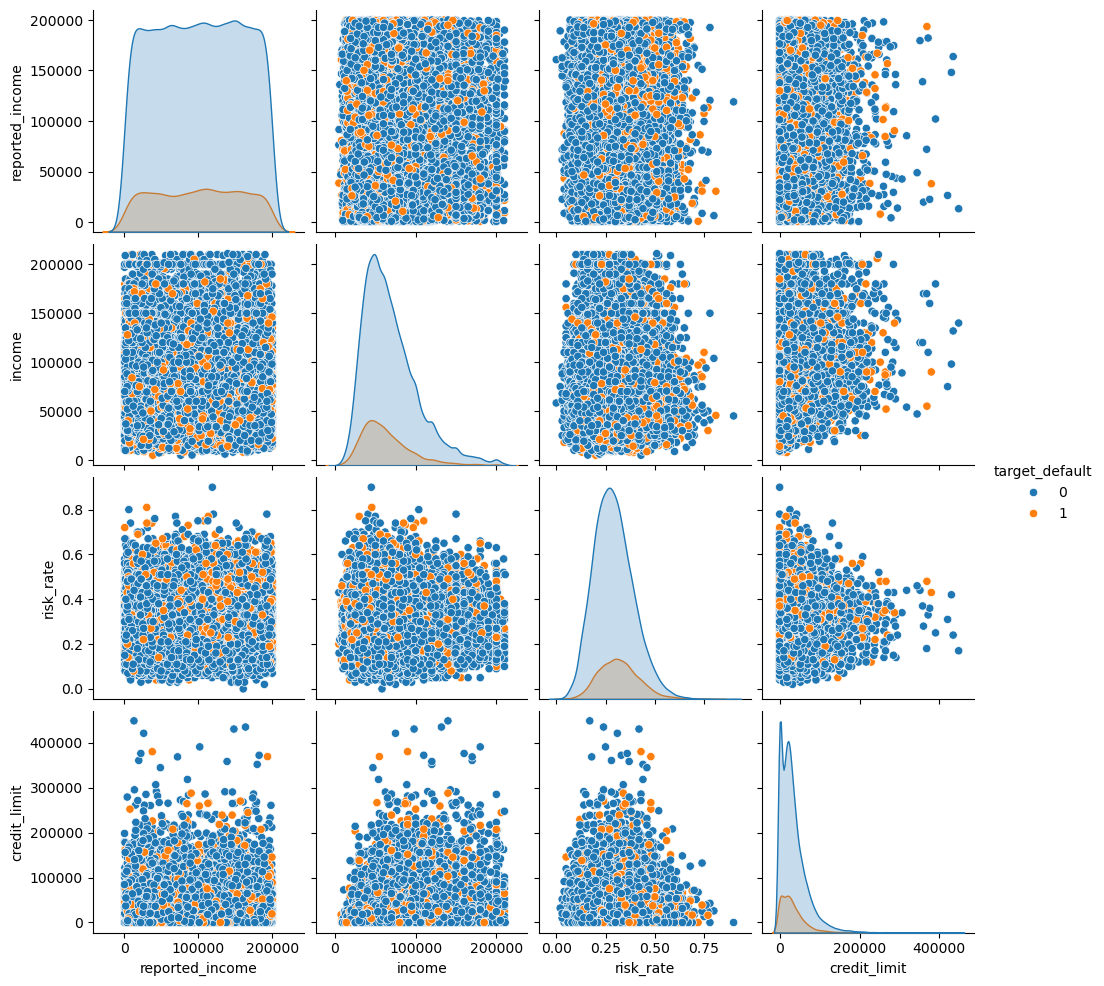

In [391]:
cols = ['reported_income', 'income', 'risk_rate', 'credit_limit']

sns.pairplot(cred_risk_df_clean, vars = cols, hue = 'target_default')

Já essas variáveis apresentam distribuições bem distintas das curvas aproximadamente normais das variáveis de `score`. Tirando a variável `reported_income`, todas as outras são enviesadas em valores pequenos. Apenas a variável `risk_rate` se aproxima mais com uma normal centrada em torno da média (~0,3), pois é um atributo que representa uma probabilidade.

Com relação aos gráficos de dispersão, não temos aparentemente nenhuma correlação significativa entre essas variáveis. Há uma concentração de pontos da classe de inadimplentes para valores de `risk_rate` e `reported_income` altos, o que indica talvez que pessoas que reportam ter uma renda maior, normalmente são clientes de maior risco de inadimplência. Porém, não é possível aferir isso com certeza a partir desses gráficos.

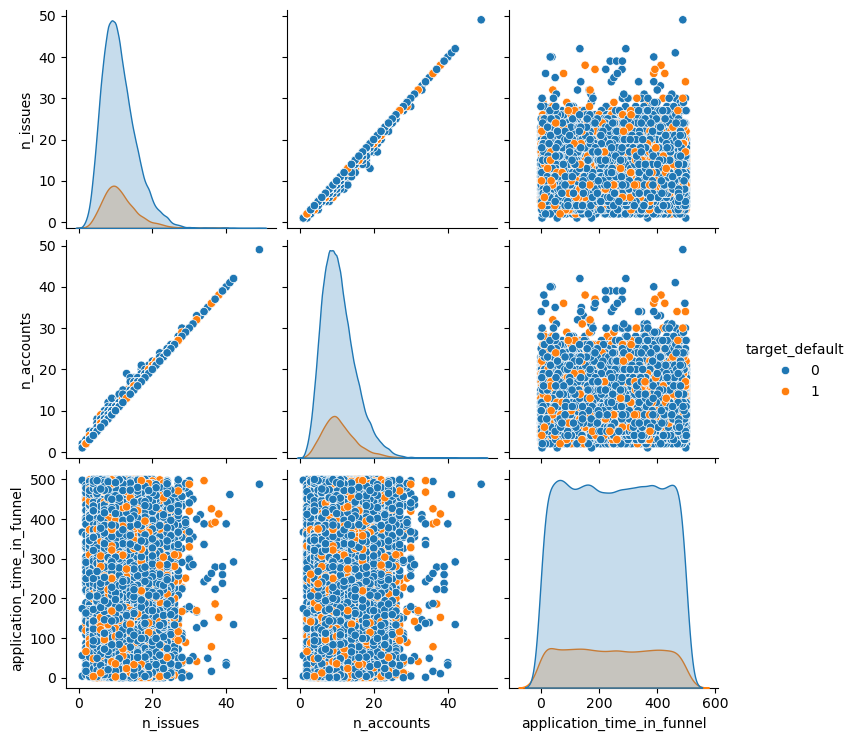

In [392]:
cols = ['n_issues', 'n_accounts', 'application_time_in_funnel']

sns.pairplot(cred_risk_df_clean, vars = cols, hue = 'target_default')

Dentre todos os atributos, o único par que apresentou uma correlação clara foi `n_accounts` e `n_issues`, com uma relação linear que mostra que um número grande de contas está associado a um maior número de problemas relacionado a essas contas. O restante das variáveis apresentam os dados dispersos entre as duas classes.

### LabelEncoder das variáveis categóricas

In [395]:
cat_cols = cred_risk_df_proc.select_dtypes(include = 'O').columns

for col in cat_cols:
    le = LabelEncoder()
    cred_risk_df_proc[col + '_encoded'] = le.fit_transform(cred_risk_df_proc[col])
    cred_risk_df_proc.drop(col, axis = 1, inplace = True)

In [396]:
cred_risk_df_proc.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,...,n_issues,application_time_in_funnel,external_data_provider_email_seen_before,reported_income,latitude,longitude,score_1_encoded,score_2_encoded,marketing_channel_encoded,shipping_state_encoded
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,...,18.0,444,51.0,57849.0,-29.151546,-51.138646,0,10,2,12
1,0,370.0,97.062615,0.942655,92.002546,0.24,12005.99,36.0,39726.0,100018.91,...,14.0,346,17.0,4902.0,-19.687711,-47.941515,3,16,5,20
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25018.0,65023.65,...,10.0,6,9.0,163679.0,-28.748024,-51.867279,3,9,7,19
3,0,510.0,101.599485,0.987673,94.902491,0.32,12005.99,36.0,54591.0,68830.01,...,19.0,406,38.0,1086.0,-17.520650,-39.758011,0,21,7,17
4,0,500.0,98.474289,0.532539,118.126207,0.18,12005.99,36.0,25018.0,60011.29,...,10.0,240,46.0,198618.0,-16.574259,-39.909901,2,1,2,12


Com o `LabelEncoder`, cada variável categórica teve associado a cada categoria um número inteiro. Assim, agora temos todas as variáveis numéricas no conjunto de dados, para facilitar as interpretações dos algoritmos.

### Separação entre treino e teste

Inicialmente, iremos separar os dados entre treino e teste. O conjunto de teste será separado para o modelo final, como medida de performance em dados nunca vistos. A divisão será de 70% para o conjunto de treino e 30% para o conjunto de testes.

In [397]:
scaled_df = cred_risk_df_proc.copy()
# Separar entre treino e teste
train = scaled_df.sample(frac = .7, random_state = 3)
test = scaled_df.drop(index = train.index, axis = 0).drop(columns = 'target_default', axis = 1)

Com os dois conjuntos de dados separados, iremos agora definir a matriz de atributos e a variável-alvo a partir do conjunto de treino. Em seguida, iremos fazer outra divisão, mas desta vez entre conjunto de treino e validação. O conjunto de validação será usado para avaliação de performance dos modelos candidatos ao longo do processo de modelagem.

In [398]:
X = train.drop('target_default', axis = 1)
y = train['target_default']

# Separando entre treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size = .7, 
                                                  random_state = 3
                                                  )
# Informações sobre os conjuntos divididos
print(
    'Treino:',
    f'\nX_train: {X_train.shape}',
    f'\nX_val: {X_val.shape}',
    '\n\nValidação:',
    f'\ny_train: {y_train.shape}',
    f'\ny_val: {y_val.shape}' 
)

Treino: 
X_train: (19440, 23) 
X_val: (8332, 23) 

Validação: 
y_train: (19440,) 
y_val: (8332,)


## Construção dos modelos

Agora que temos os conjuntos de treino, validação e teste devidamente separados, vamos prosseguir com a construção dos modelos. Inicialmente, vamos construir um modelo básico, não parametrizado, para estabelecer uma performance base.

Para criar e avaliar os modelos, vamos criar uma função que realiza alguns pré-processamentos nos dados a partir de um Pipeline que irá padronizar os dados, e balanceá-los.

Para padronizar os dados, utilizaremos o `StandardScaler`. A padronização transforma os dados para que tenham média zero e desvio-padrão um. O processo centraliza os dados e os dimensiona segundo suas distribuições. É particularmente útil para ser utilizado em algoritmos que assumem uma distribuição normal para os dados. Além disso, colocar todos os dados em uma escala similar diminui as chances de viés por parte do algoritmo durante a modelagem.

Já para o balanceamento, utilizaremos o `RandomUnderSampler`. Sempre que lidamos com classes desbalanceadas, devemos realizar o balanceamento após a divisão e no conjunto de treinos para 1) preservar a distribuição das classes nos conjuntos de validação e teste, e 2) evitar vazamento de dados.

Também utilizaremos a técnica da validação cruzada para validar o modelo em diversas porções do conjunto de dados.

Vamos criar o baseline com o algoritmo de `RandomForestClassifier`.

In [405]:
def baseline_model(X: np.array, y: np.array, clf):
    
    X = np.array(X)
    y = np.array(y)

    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
            ])
    scores = cross_val_score(pipeline, X, y, cv = 5, scoring = 'accuracy')

    mean_acc = scores.mean()
    std_acc = scores.std()
    print(f'Acurácia: {mean_acc:.3f} (+/- {std_acc:.3f})')

    return scores.mean()

In [406]:
rf = RandomForestClassifier()
baseline_model(X_train, y_train, rf)

Acurácia: 0.843 (+/- 0.002)


0.8431584362139917

In [420]:
class_balance_methods = {
    'RandomUnderSampler': RandomUnderSampler(),
    'RandomOverSampler': RandomOverSampler(),
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'TomekLinks': TomekLinks()
}

def balanced_models(class_balance_methods: dict, clf, X, y):

    results = []

    X = np.array(X)
    y = np.array(y)

    for method_name, sampler in class_balance_methods.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('class_balance', sampler),
            ('classifier', clf)
        ])

        acc_score = cross_val_score(pipeline, X, y, cv = 5, scoring = 'accuracy')
        results.append({'Método': f'{method_name}', 'Acurácia': f'{acc_score.mean():.3f}'})
    
    results_df = pd.DataFrame(results)

    return results_df

In [421]:
balanced_models(class_balance_methods, rf, X_train, y_train)

,Método,Acurácia
0,RandomUnderSampler,0.671
1,RandomOverSampler,0.844
2,SMOTE,0.829
3,ADASYN,0.832
4,TomekLinks,0.844
